## This does the comparison between fit function and GP fitting on 3.6fb-1 of data and injecting a Gaussian signal based on a fit to our q* samples

In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
import george
from george.kernels import MyDijetKernelSimp, ExpSquaredCenteredKernel, SignalKernel


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

#Fix root
import sys
sys.path.append("/usr/local/Cellar/root/6.12.04_1/lib/root/")
sys.path.append("/Library/Python/2.7/site-packages/")

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt



Welcome to JupyROOT 6.12/04


/usr/local/Cellar/python/2.7.14_3/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py:252: RuntimeWarning: creating converter for unknown type "_Atomic(bool)"
  value = getattr(object, key)


## Inputs

In [3]:
#Full bin centers (xvalO), counts (yvalO), bin width (xerrO), and bin low edges (xlowO) from ATLAS
xvalO = np.load("newoutputs/xvalO.npy")
yvalO = np.load("newoutputs/yvalO.npy")
xerrO = np.load("newoutputs/xerrO.npy")
xlowO = list(np.load("newoutputs/xlowO.npy"))

#Same, but with bins with zero counts removed. GP fits better without zero counts
xval = np.load("newoutputs/xval.npy")
yval = np.load("newoutputs/yval.npy")
xerr = np.load("newoutputs/xerr.npy")

#10000 toys - created from smoothed data with Poisson noise
toyList = np.load("newoutputs/toyList.npy")
fixedHyperparams = np.load("newoutputs/fixedHyperparams.npy")

#injected gaussian signals 
sigToys = np.load("newoutputs/signalToys.npy")
sigToysO = np.load("newoutputs/signalToysO.npy")
standardParamSets = [(1500,2000,250), (750 ,2500, 250), (200, 3000, 250), (75, 3500, 250), (50, 4000, 250), 
             (25, 4500, 250), (20, 5000, 250), (15,5500, 250), (15, 6000,250)]


### Calculate z values and chi squared 

In [4]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2


### poisson likelihood

In [5]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

### remove zero count bins to use for GP fits. Add back in zero bins for final prediction

In [6]:
def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

def addZeros(data, xtoy):
    for ik, k in enumerate(xvalO):
        if ik <len(xtoy):
            if k == xtoy[ik]:
                continue
            else:
                if ik <= len(xtoy):
                    xtoy = np.insert(xtoy, ik, k)
                    data = np.insert(data, ik, 0)
        else:
            xtoy = np.append(xtoy, k)
            data = np.append(data, 0)
    return data, xtoy

## signal+background and background only plotted together

In [7]:
def makePrettyPlots_sb(xs_l, xs, ys_b, ys_sb, bkgs, bkgs_l, bkgsigs,xlow, title, ymax = 3e5):
    #f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1, 1]})
    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    #f.suptitle(title, fontsize=35, y=1.01)
    dataPlot = ax1.errorbar(xs, ys_sb, marker='o', ls='None', yerr = np.sqrt(ys_sb), c='black', markersize=10, label="Toy data with injected signal")
    bkg1Plot, = ax1.plot(xs_l, bkgs_l, color='g', linewidth=3.0, label="Gaussian Process background only")
    bkg2Plot, = ax1.plot(xs, bkgsigs, color='r', linewidth=3.0, label="Gaussian Process signal-plus-background")
    ax1.legend(prop={'size':17})
    ax1.set_ylabel('Events per bin', fontsize=35)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.09, ymax])
    ax1.tick_params(axis='y', labelsize=25)

    #bin by bin significance   
    zvals_1, chi2_1 = calcSignificance(ys_sb, bkgs)
    print "chi2 bkg+signal mu=0", chi2_1
    h1 = Hist(xlow,markersize=0)
    for x in range(len(zvals_1)):
        if zvals_1[x] == np.inf or zvals_1[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals_1[x]  
    h1.fillstyle = 'solid'
    h1.fillcolor = 'green'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")

    rplt.bar(h1, xerr=None, yerr=None, axes=ax2)
    ax2.axhline(0, color='black', lw=1)
    #ax2.set_ylabel('Significance', fontsize=15)
    ax2.set_ylabel('Sig.', fontsize=35, labelpad=23)
    ax2.set_xscale('log')
    ax2.tick_params(axis='y', labelsize=25)
    ax2.set_xlim([1000, 7500])
    ax2.set_ylim([-5, 5])
    ax2.annotate("background-only fit residuals",(2020,-3.5), fontsize=25)

    
    zvals_2, chi2_2 = calcSignificance(ys_sb, bkgsigs)
    print "chi2 bkg+signal", chi2_2
    h2 = Hist(xlow,markersize=0)
    for x in range(len(zvals_2)):
        if zvals_2[x] == np.inf or zvals_2[x] == -np.inf: h2[x] = 20
        else: h2[x] = zvals_2[x]  
    h2.fillstyle = 'solid'
    h2.fillcolor = 'red'
    h2.linecolor = 'black'
    h2.linewidth = 1
    h2.Draw("histX0")
    rplt.bar(h2, xerr=None, yerr=None, axes=ax3)
    ax3.axhline(0, color='black', lw=1)
    ax3.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=35)
    #ax3.set_ylabel('Significance', fontsize=15)
    ax3.set_ylabel('Sig.', fontsize=35, labelpad=23)
    ax3.set_xscale('log')
    ax3.tick_params(axis='y', labelsize=25)
    ax3.tick_params(axis='x', labelsize=25)
    ax3.set_ylim([-5, 5])
    ax3.set_xlim([1000, 7500])
    ax3.annotate("signal+background fit residuals",(2020,-3.5), fontsize=25)
    
    ax3.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax3.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax3.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax3.set_xticklabels(labels)

    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()
    


### signal only component of signal+background fit

In [8]:
def makePrettyPlots_signalOnly(xs, dM_GP, GPs, data, sig, mass, title):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(12,12))
   # f.suptitle(title, fontsize=35, y=1.01)
    dataMinusGPbPlot = ax1.errorbar(xs, dM_GP, marker='o', ls='None', yerr = np.sqrt(data), c='black', markersize=10, label="Toy data - Gaussian Process background")
    dataPlot = ax1.plot(xs, GPs, linewidth=3.0, c='green',label="Gaussian Process signal")
    sigPlot = ax1.plot(xs, sig, linewidth=3.0, c='red',label="Injected signal")


    ax1.legend(prop={'size':17})
    ax1.set_ylabel('Events per bin', fontsize=35)
    ax1.tick_params(axis='y', labelsize=35)
    ax1.set_xscale('log')

    ax1.set_xlim([max(mass*0.75, 1000), mass*1.5])
   # ax1.set_ylim([-3.5*max(GPs), 3.5*max(GPs)])
    ax1.set_ylim([-50, 75])
    ax1.tick_params(axis='x', labelsize=35)
    major_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 1000)
    ax1.set_xticks(major_ticks)

    minor_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 100)
    ax1.set_xticks(minor_ticks, minor=True)  

    labels = [str(int(j)/1000) for j in major_ticks]
    ax1.set_xticklabels(labels)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=35)
    
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)  

    plt.show()

In [9]:
def makePrettyPlots_signalOnly2(xs, data, GPs, mass, title):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=35, y=1.01)
    dataPlot = ax1.errorbar(xs, data, marker='o', ls='None', yerr = np.sqrt(data), c='black', markersize=10, label="Injected Signal")
    sigPlot = ax1.plot(xs, GPs, linewidth=3.0, c='green',label="Gaussian Process signal")


    ax1.legend(prop={'size':17})
    ax1.set_ylabel('Events per bin', fontsize=35)
    ax1.tick_params(axis='y', labelsize=35)
    ax1.set_xscale('log')

    ax1.set_xlim([max(mass*0.75, 1000), mass*1.5])
    #ax1.set_ylim([-3, 1.5*max(GPs)])
    ax1.set_ylim([-0.1, 40])
    ax1.tick_params(axis='x', labelsize=35)
    major_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 1000)
    ax1.set_xticks(major_ticks)

    minor_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 100)
    ax1.set_xticks(minor_ticks, minor=True)  

    labels = [str(int(j)/1000) for j in major_ticks]
    ax1.set_xticklabels(labels)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=35)
    
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

### Mean function for GP

In [10]:
def model_gp(params, t, xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

### piecewise linear function for signal

In [11]:
def peak(t, amp, center, width, xerr):
    output = np.zeros(len(t))
    slope=0.5
    for i, c in enumerate(t):
        if c < center-width or c > center-width: pass
        if c > center-width and c < center: 
            output[i]=(slope*c-slope*center+amp)
        if c > center and c < center+width:
            output[i]=(-slope*c+slope*center+amp)
    output = [s if s > 0 else 0 for s in output]
    return output

### right triangle function for signal

In [12]:
def triangle(t, amp, center, width, xerr):
    output = np.zeros(len(t))
    offset=10.
    slope1 = amp/(2.*width-offset)
    y1 = amp*(-center+width)/(2*width-offset)
    slope2 = -amp/offset
    y2 = amp*(center+width)/offset
    for i, c in enumerate(t):
        if c < center-width or c > center-width: pass
        if c > center-width and c < center+width-offset: 
            output[i]=slope1*c+y1
        if c > center+width-offset and c < center+width:
            output[i]=slope2*c+y2
    output = [s if s > 0 else 0 for s in output]
    return output

### square signal function

In [13]:
def square(t, amp, center, width, xerr):
    output = np.zeros(len(t))
    for i, c in enumerate(t):
        if c < center-width or c > center-width: pass
        if c > center-width and c < center+width: output[i]=amp
    return output

### Gaussian signal function

In [14]:
def gaus(x, amp, center, width, xerr):
    return amp*(np.exp(-(x-center)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xerr

### Smearing functions - use Gaussian kernel to smooth out signals

In [15]:
truth_steps = np.logspace(np.log10(900), np.log10(8000), 200)
truth_step_size = np.append(np.diff(truth_steps),np.diff(truth_steps)[-1]) 
def smearO(s, signal_shape):
    smeared_counts=np.zeros(len(xvalO))
    for xi, x in enumerate(xvalO):
        gaus = truth_step_size*ss.norm.pdf(x, truth_steps, truth_step_size*2.)
        smeared_counts[xi]=np.sum((s+signal_shape)*gaus)
    smeared_counts = [s if s > 0 else 0 for s in smeared_counts]
    noisy_smeared_counts=np.random.poisson(smeared_counts)
    return smeared_counts, noisy_smeared_counts

In [16]:
truth_steps = np.logspace(np.log10(900), np.log10(8000), 200)
truth_step_size = np.append(np.diff(truth_steps),np.diff(truth_steps)[-1]) 
def smear(s, signal_shape):
    smeared_counts=np.zeros(len(xval))
    for xi, x in enumerate(xval):
        gaus = truth_step_size*ss.norm.pdf(x, truth_steps, truth_step_size*2.)
        smeared_counts[xi]=np.sum((s+signal_shape)*gaus)
    smeared_counts = [s if s > 0 else 0 for s in smeared_counts]
    noisy_smeared_counts=np.random.poisson(smeared_counts)
    return smeared_counts, noisy_smeared_counts

## OLD KERNEL

### Fit signal GP hyperparameters by minimizing george likelihood with minuit. Keep hyperparameters for background GP fixed

In [17]:
class logLike_gp_fitgpsig:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams #best_fit_gp
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel = kernel1+kernel2
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf  
        
def fit_gp_fitgpsig_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(100):
        init0 = np.random.random() * 3000.
        init1 = np.random.random() * 3000.
        init2 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, 
                  error_A = 1., error_mass = 1., error_tau = 1.,
                  limit_A = (1, 1e5), limit_mass = (1000, 7000), limit_tau = (100, 500))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

### Gaussian signals

parameters (300, 3500, 250)
(343.8592239178924, 3522.280782716122, 277.51953506617826)
(341.27685499068497, 3522.2396219077623, 277.80330391745787)
(343.07909922296426, 3522.0365639951847, 277.7419564638477)
(341.3735456130932, 3521.8894524486977, 277.8321078335278)
(341.7998562540669, 3521.920954684641, 277.7896763675485)
(341.612710295762, 3521.943051722324, 277.77849883618785)
A, mass, tau 341.612710296 3521.94305172 277.778498836


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 65.02337081607651


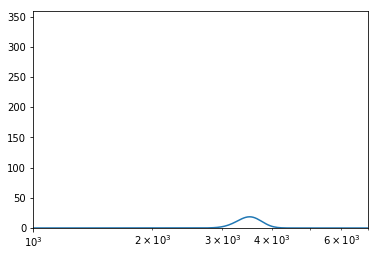

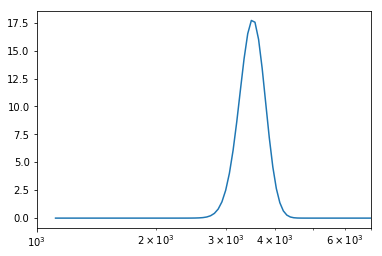

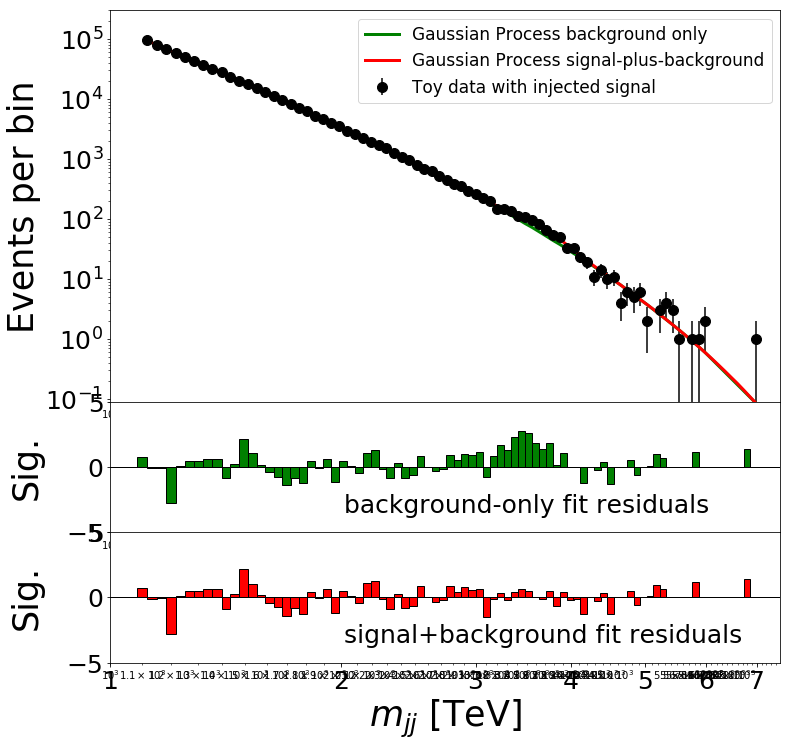

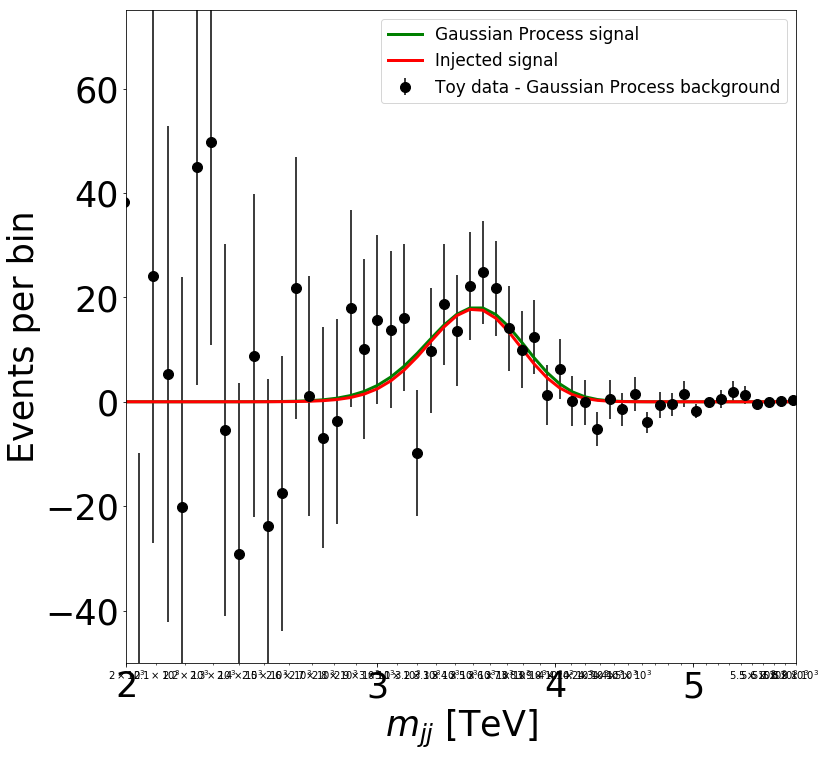

In [18]:
aa={}
mm={}
ww={}
#standardParamSets = [(1500,2000,300), (800 ,2500, 250), (500, 3000, 250), (300, 3500, 250), (100, 4000, 250), 
#                     (75, 4500, 250), (50, 5000, 250), (25,5500, 250), (15, 6000,250)]

standardParamSets = [(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    aa[m]=[]
    mm[m]=[]
    ww[m]=[]

    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        aa[m].append(A)
        mm[m].append(mass)
        ww[m].append(tau)
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        
        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)        
        

        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)
        

for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet
    print np.mean(aa[m]), np.mean(mm[m]), np.mean(ww[m])
    

### Peak signals

parameters (60, 3500, 250)
(1.0276059097643429, 1000.000000000035, 120.87737137250471)
(1.7459806638036341, 1005.3997139863346, 100.00000152761375)
(1.2090079299300645, 1000.0000000000587, 100.85526093517987)
(788.3204367704527, 3538.8662979571804, 109.33242174122844)
(786.6871497237921, 3538.860748049118, 109.39989486465987)
(786.2645701939249, 3538.8693416813526, 109.40931127140301)
A, mass, tau 786.264570194 3538.86934168 109.409311271


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 64.33028586440456


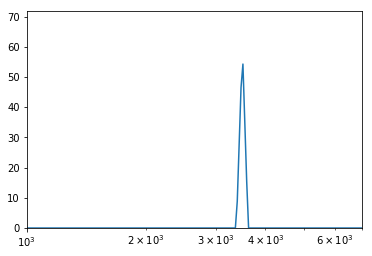

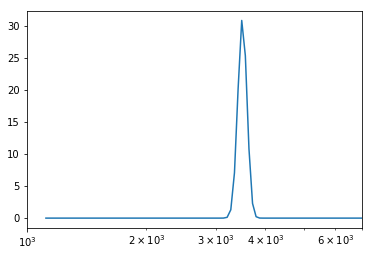

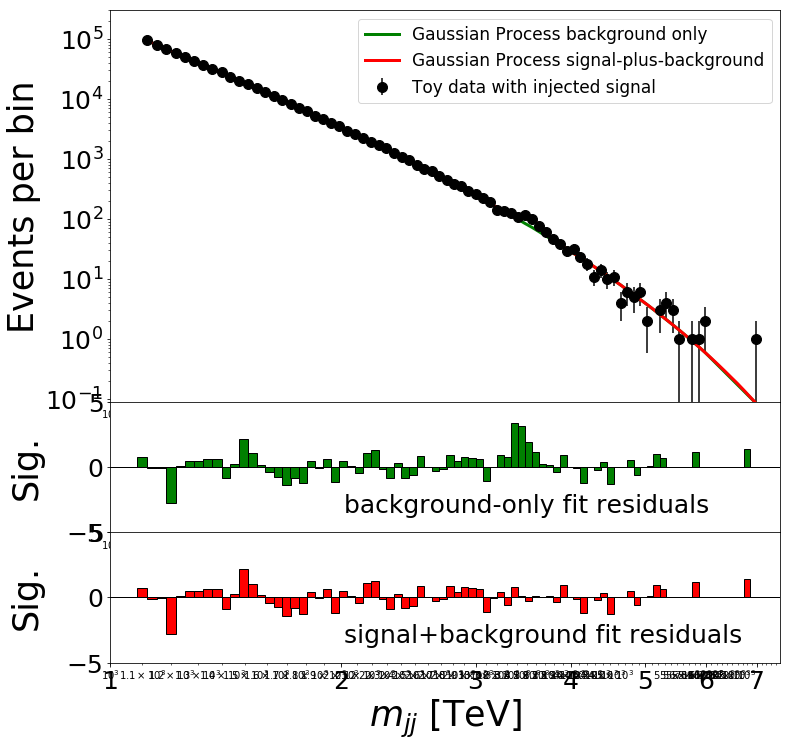

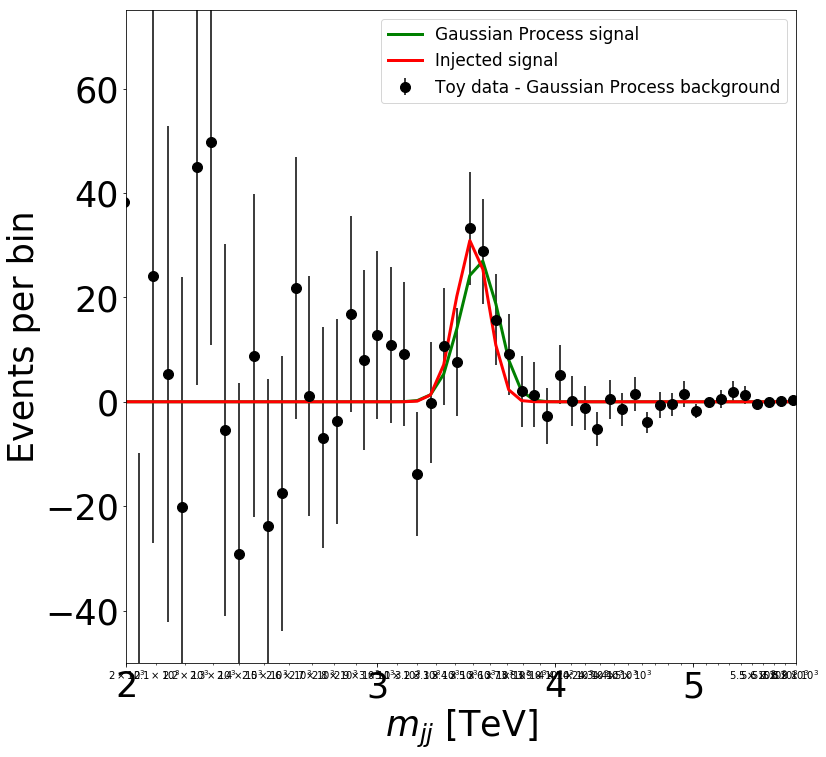

In [19]:
aa={}
mm={}
ww={}
#standardParamSets = [(200,2000,300), (100 ,2500, 250), (75, 3000, 250), (60, 3500, 250), (55, 4000, 250), 
#                     (45, 4500, 250), (40, 5000, 250), (25,5500, 250), (15, 6000,250)]
standardParamSets = [(60, 3500, 250)]

for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    aa[m]=[]
    mm[m]=[]
    ww[m]=[]

    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = peak(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        aa[m].append(A)
        mm[m].append(mass)
        ww[m].append(tau)
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        newys, newxs = addZeros(mu2, xtoy)


        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)



### square signals

parameters (20, 3500, 250)
(1.0000267268754497, 2472.226309634188, 100.00007210134265)
(3664.6299044035554, 1510.413307145095, 100.0000087468943)
(757.8200240313623, 3512.0015459791243, 170.770154090274)
(766.7288350081299, 3512.2770853844236, 170.82147171725674)
(770.2787030851886, 3512.232793541629, 170.80141089166744)
(768.9499752215702, 3512.230179414218, 170.81199762990667)
(769.2694356020447, 3512.2304216665066, 170.8034404565876)
A, mass, tau 769.269435602 3512.23042167 170.803440457


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 66.02179714116912


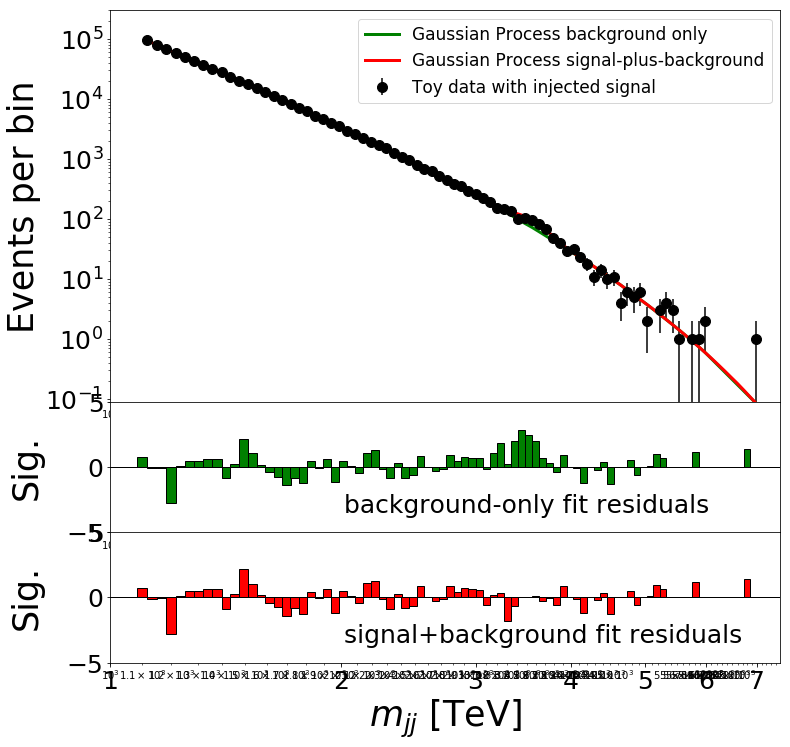

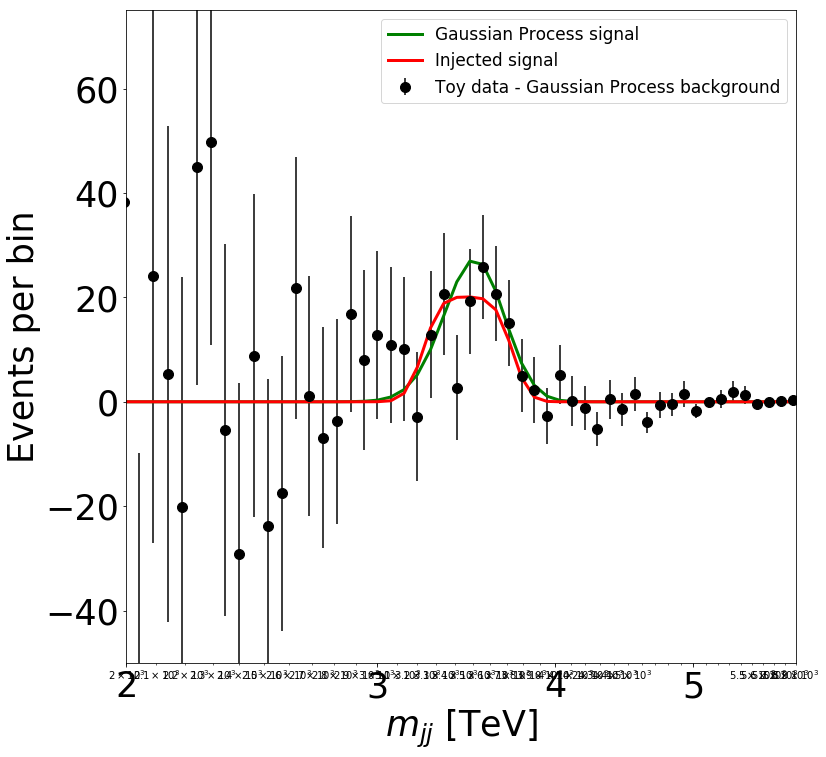

In [20]:

#standardParamSets = [(100,2000,300), (50 ,2500, 250), (30, 3000, 250), (20, 3500, 250), (15, 4000, 250), 
#                     (10, 4500, 250), (9, 5000, 250), (5,5500, 250), (4, 6000,250)]

standardParamSets = [(20, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = square(truth_steps, n, m, w, truth_step_size)
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 

        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        newys, newxs = addZeros(mu2, xtoy)

        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)



### Right Triangle

parameters (40, 3520, 250)
(1330.0163879011197, 3619.9020130291115, 119.45999828956184)
(1331.0071001827682, 3619.8174966045026, 119.43397095091153)
A, mass, tau 1331.00710018 3619.8174966 119.433970951
chi2 bkg+signal mu=0 

/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


nan
chi2 bkg+signal 65.82144293090332


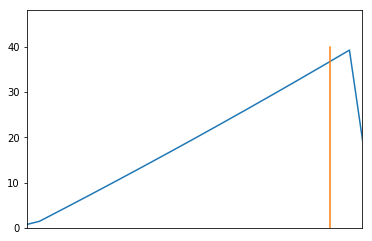

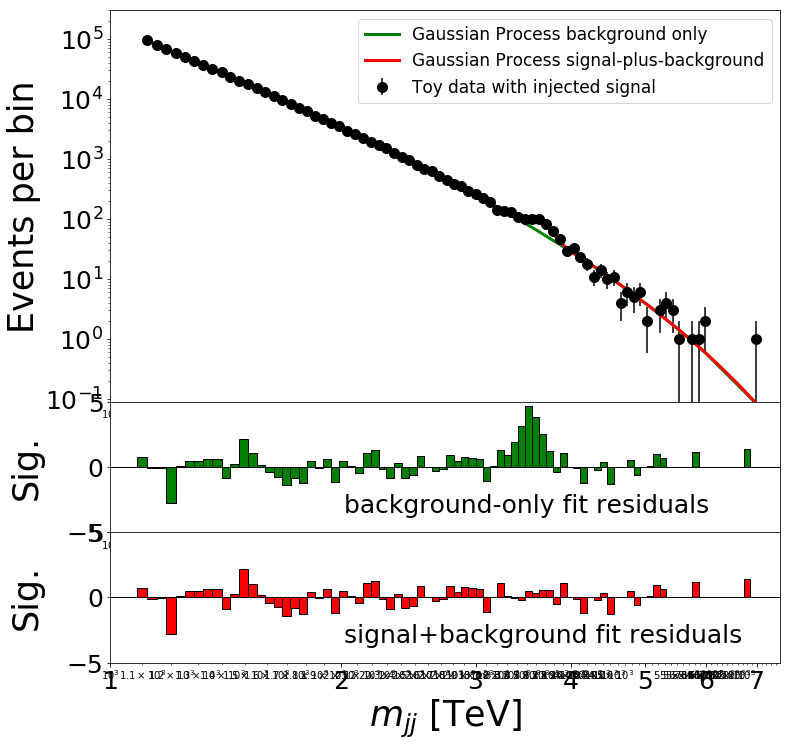

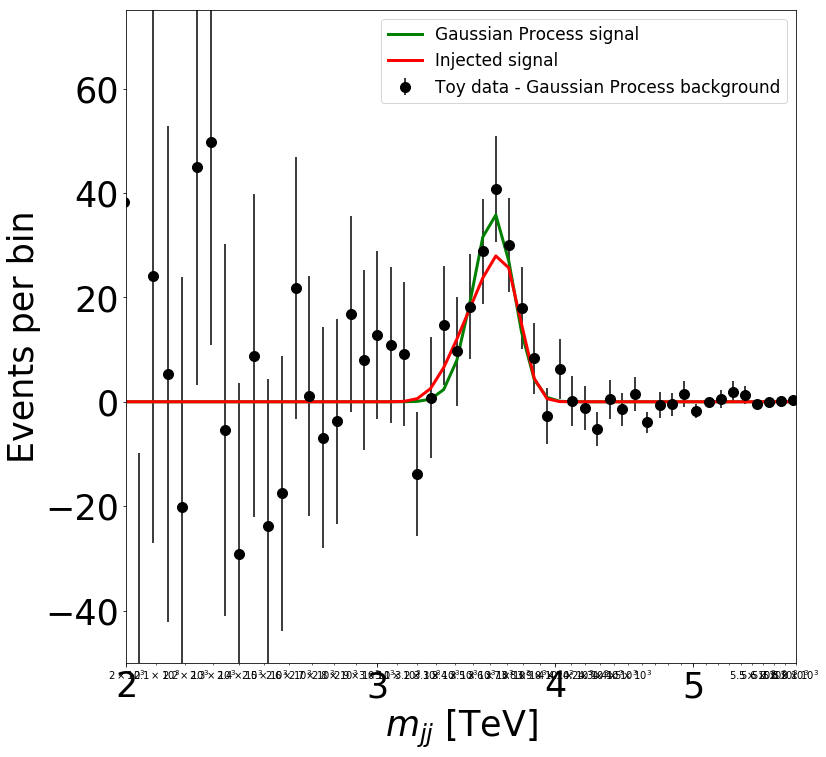

In [21]:

#standardParamSets = [(100,2000,300), (50 ,2500, 250), (30, 3000, 250), (20, 3500, 250), (15, 4000, 250), 
#                     (10, 4500, 250), (9, 5000, 250), (5,5500, 250), (4, 6000,250)]

standardParamSets = [(40, 3520, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = triangle(truth_steps, n, m, w, truth_step_size)
        
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.plot((m+w-50.)*np.ones(2),[0, n]) 
        plt.xlim([m-w,m+w])
        plt.ylim([0,1.2*n])
        plt.xscale('log')
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 

        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        newys, newxs = addZeros(mu2, xtoy)

        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)



## NEW SIGNAL KERNEL

In [22]:
class logLike_gp_fitgpsigNew:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau, L):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams 
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel = kernel1+kernel2
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf  
        
def fit_gp_fitgpsigNew_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(100):
        init0 = np.random.random() * 3000.
        init1 = np.random.random() * 3000.
        init2 = np.random.random() * 200.
        init3 = np.random.random() * 50.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, L = init3,
                  error_A = 1., error_mass = 1., error_tau = 1., error_L =1.,
                  limit_A = (1, 1e5), limit_mass = (1000, 7000), limit_tau = (100, 500), limit_L = (10, 10000))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

### Gaussian Signal

parameters (300, 3500, 250)
(1.0039181890207216, 1000.000000040828, 100.00000000062363, 45.00843271134093)
(253.32678266740405, 3687.265882813156, 434.89044969052196, 690.5155231302073)
(385.53114854382585, 3583.0771241756734, 240.78293909804955, 9998.918754100017)
(387.4705594303126, 3583.0226312705868, 240.67929044206164, 9999.110823327539)
A, mass, tau, L 387.47055943 3583.02263127 240.679290442 9999.11082333
chi2 bkg+signal mu=0 nan


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal 65.843781953538


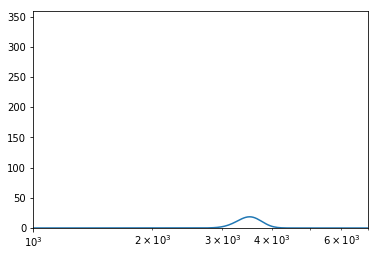

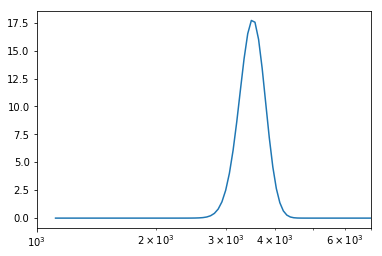

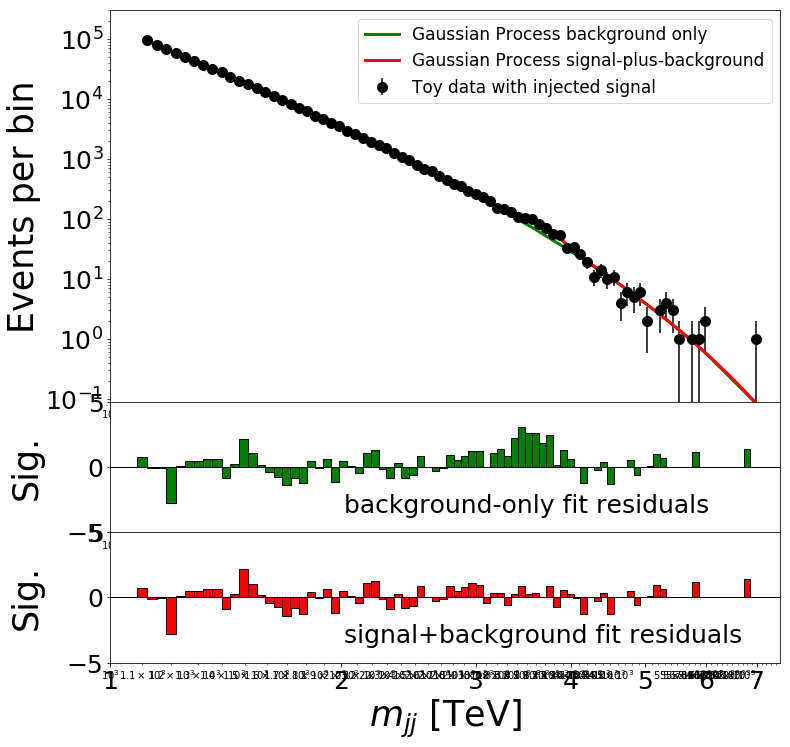

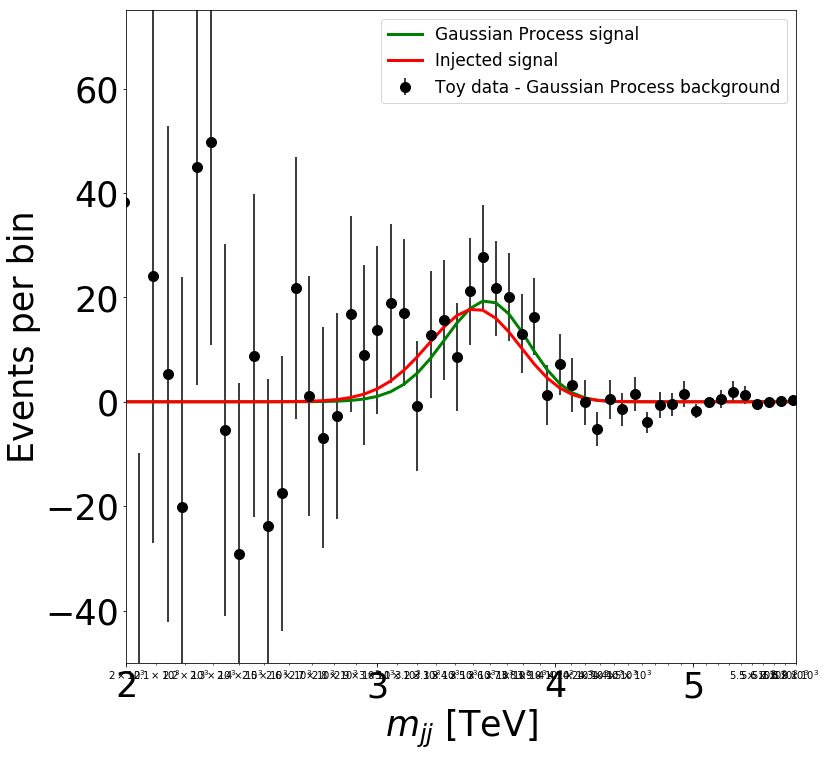

In [23]:
standardParamSets = [(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        

        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
 
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)
        

### Peak Signal

parameters (60, 3500, 250)
(1.351660854312974, 1000.0000000001635, 100.00000000000003, 39.99512141972467)
(79.44079545917283, 2976.3948109713356, 100.00404727054746, 4572.542406724012)
(29163.586044843167, 1230.955029079725, 100.00000443634676, 16.054885560360415)
(29165.64184801038, 1230.8671863016225, 100.00000237480494, 16.169183517318608)
(3752.6030842405153, 1758.7886087973222, 100.00023312566131, 112.44951087377211)
(800.7258440077873, 3527.2390997693965, 112.421182123308, 9937.460015353308)
(803.2137781915153, 3527.1495984939083, 112.47873941993221, 9970.797479594687)
A, mass, tau, L 803.213778192 3527.14959849 112.47873942 9970.79747959
chi2 bkg+signal mu=0 nan


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal 65.90526252968364


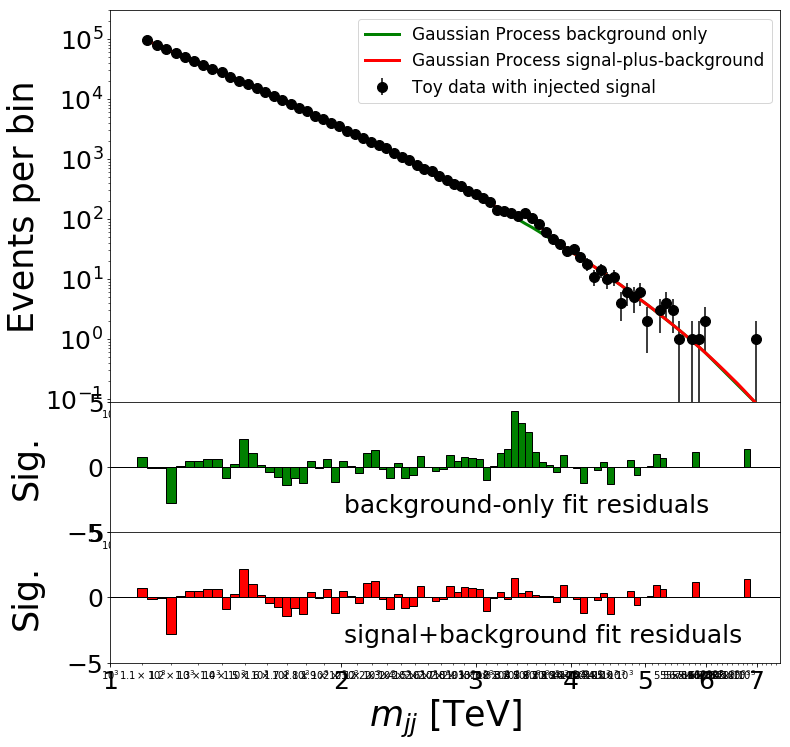

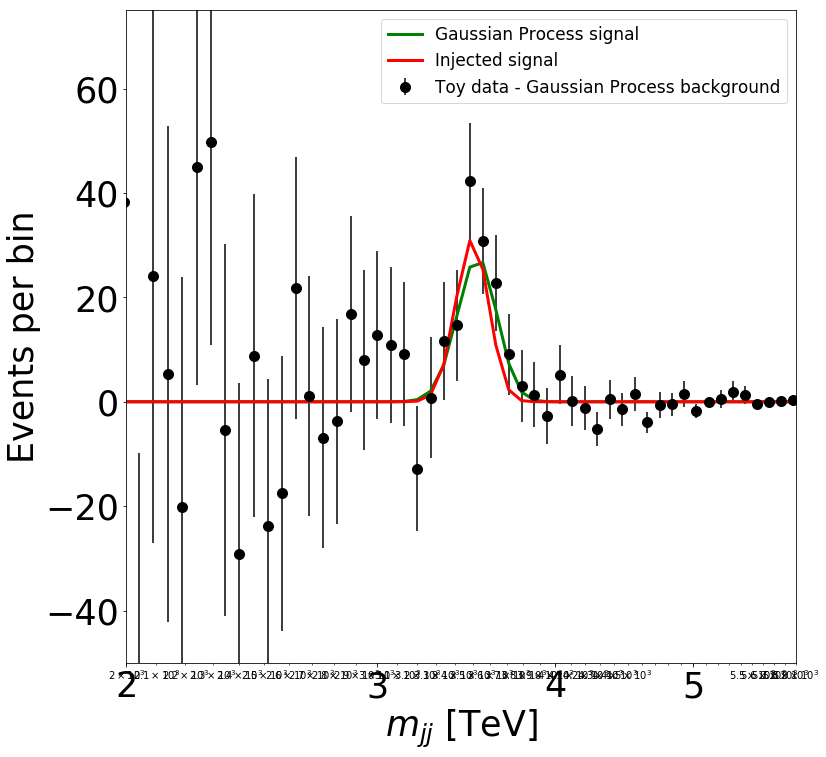

In [24]:
standardParamSets = [(60, 3500, 250)]

for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = peak(truth_steps, n, m, w, truth_step_size)

        
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO

        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 

        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        newys, newxs = addZeros(mu2, xtoy)


        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)




### Square Signal

parameters (20, 3500, 250)
(144.76546818962464, 3458.3484157355156, 499.9996288838056, 391.8473970038759)
(746.7909392707652, 3554.0695758689935, 146.31437806344385, 9995.259706684177)
(747.5802224049029, 3554.039886666723, 146.27248511904708, 9998.915385024395)
A, mass, tau, L 747.580222405 3554.03988667 146.272485119 9998.91538502
[3.12802545e-02 2.43933699e-02 1.89512117e-02 1.46678286e-02
 1.13098886e-02 8.65522069e-03 6.59874925e-03 5.01197348e-03
 3.77818502e-03 2.83740506e-03 2.12286861e-03 1.57634840e-03
 1.16612462e-03 8.59411935e-04 6.28615541e-04 4.58070692e-04
 3.32539744e-04 2.39597305e-04 1.71335604e-04 1.22061013e-04
 8.66303317e-05 6.10225434e-05 4.26616797e-05 2.96014453e-05
 2.04621631e-05 1.40913897e-05 9.63126713e-06 6.53341658e-06
 4.39870251e-06 2.93924746e-06 1.94928360e-06 1.28304305e-06
 8.38175080e-07 5.43445719e-07 3.49913731e-07 2.65336326e-07
 1.50687802e-06 1.37149785e-05 1.08511213e-04 7.36630603e-04
 4.25288692e-03 2.06961651e-02 8.41242749e-02 2.8299023

/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal 63.93902366943715


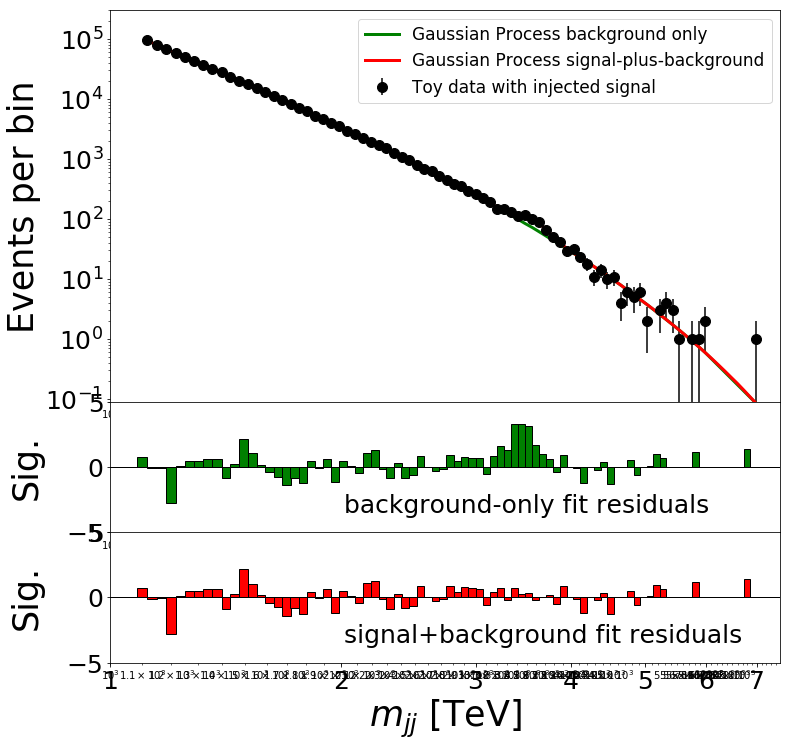

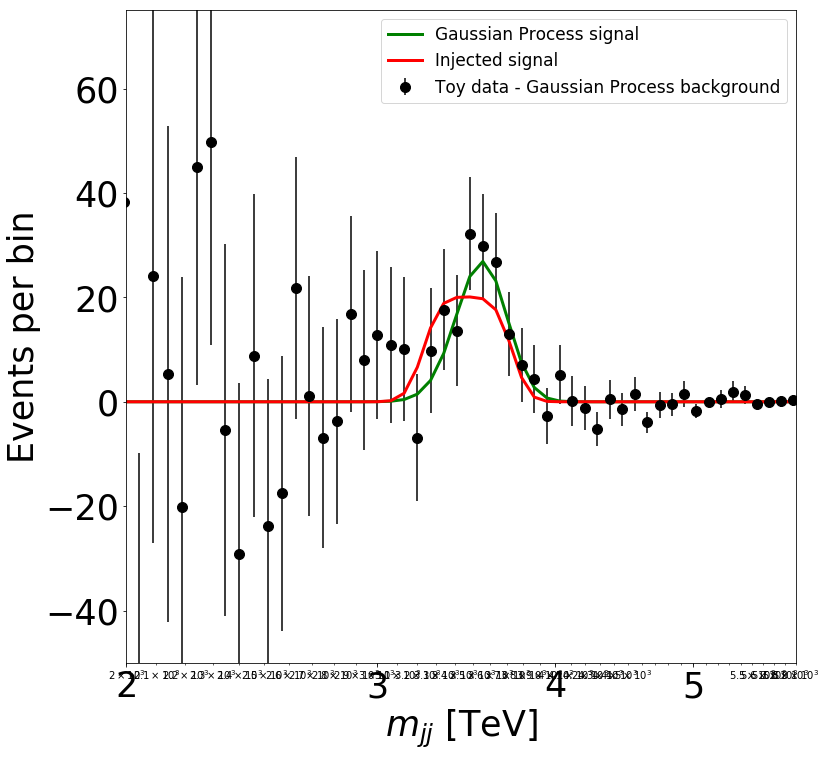

In [25]:
standardParamSets = [(20, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = square(truth_steps, n, m, w, truth_step_size)

        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
  
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp, covGP = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        print np.sqrt(np.diag(covGP))
        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        newys, newxs = addZeros(mu2, xtoy)

        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)





### Right Triangle

parameters (40, 3520, 250)
(1.0104338137403523, 1000.0000000001702, 100.0, 39.52212793673063)
(1424.235653520058, 3640.08564700447, 115.5835017216019, 9975.810851829983)
(1421.235576983386, 3640.2036326814928, 115.60892882613692, 9990.848438321056)
(1410.7641489450439, 3640.177111595028, 115.581233257139, 9993.323038247734)
(1416.0853479692444, 3640.1778569642725, 115.65032794295438, 9996.452753303714)
A, mass, tau 1416.08534797 3640.17785696 115.650327943 9996.4527533
chi2 bkg+signal mu=0 nan


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal 66.70919196094182


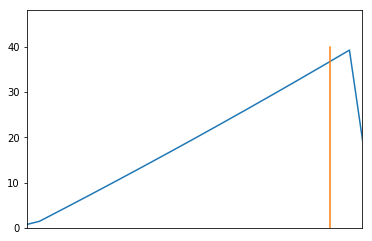

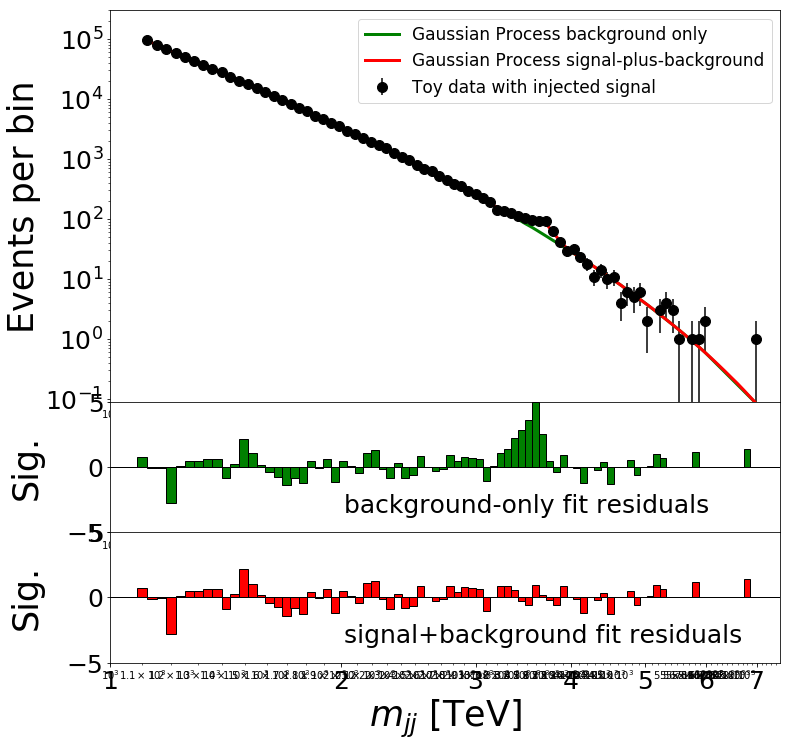

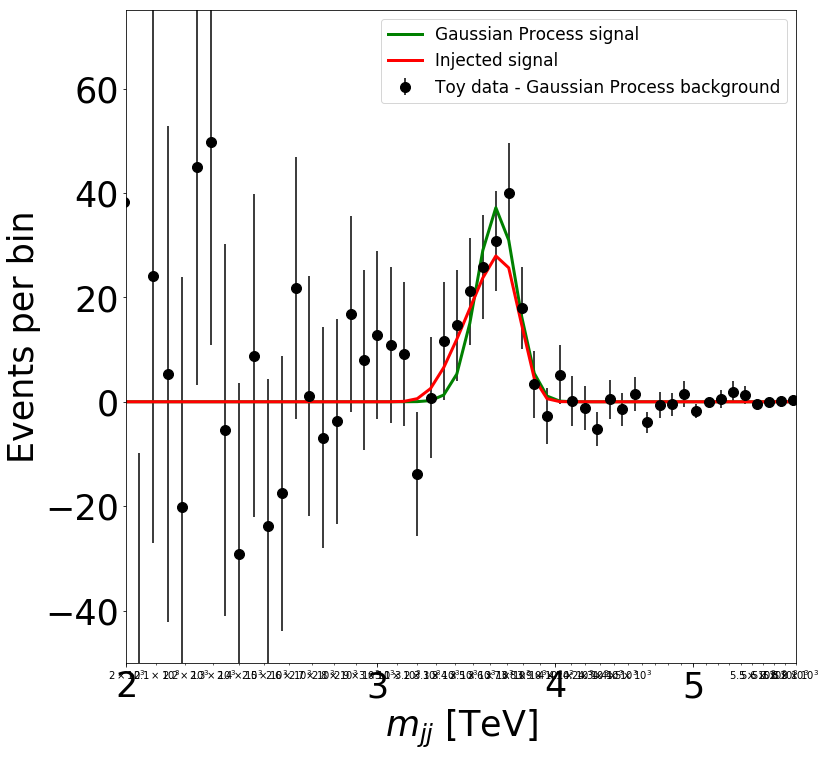

In [26]:
standardParamSets = [(40, 3520, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = triangle(truth_steps, n, m, w, truth_step_size)
        
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.plot((m+w-50.)*np.ones(2),[0, n]) 
        plt.xlim([m-w,m+w])
        plt.ylim([0,1.2*n])
        plt.xscale('log')
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 

        print "A, mass, tau", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        newys, newxs = addZeros(mu2, xtoy)

        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)



## SIGNAL ONLY FIT

In [27]:
class logLike_gp_fitgpsigonlyNew:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau, L):
        kernel = A * SignalKernel(m = mass, t = tau, L = L)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y)
        except:
            return np.inf  
        
def fit_gp_fitgpsigonlyNew_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(200):
        init0 = np.random.random() * 3000.
        init1 = np.random.random() * 3000.
        init2 = np.random.random() * 200.
        init3 = np.random.random() * 50.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, L = init3,
                  error_A = 1., error_mass = 1., error_tau = 1., error_L = 1.,
                  limit_A = (1, 100), limit_mass = (1000, 7000), limit_tau = (100, 500), limit_L = (100, 10000))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

In [28]:
class logLike_gp_fitgpsigonly:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau):
        kernel = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y)
        except:
            return np.inf  
        
def fit_gp_fitgpsigonly_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(200):
        init0 = np.random.random() * 3000.
        init1 = np.random.random() * 3000.
        init2 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, 
                  error_A = 1., error_mass = 1., error_tau = 1.,
                  limit_A = (1, 100), limit_mass = (1000, 7000), limit_tau = (100, 500))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

### Gaussian Signal

parameters (300, 3500, 250)
(99.99991245373796, 1322.2626441178268, 134.00632158218696)
(99.99992102328474, 1000.0057696752295, 100.00038122328556)
(99.99649606914153, 3596.216630771084, 114.41973454612311)
(99.99999999883572, 3596.4009146892754, 114.43341794380426)
(99.99999999420191, 3596.399562524728, 114.4331408080164)
A, mass, tau 99.9999999942 3596.39956252 114.433140808
[2.23767779e-102 1.11136590e-099 5.56960311e-097 2.80564391e-094
 1.41511116e-091 7.77466699e-089 4.23135665e-086 2.27192062e-083
 1.30341380e-080 7.29421793e-078 3.96453267e-075 2.25610343e-072
 1.23216569e-069 6.42883699e-067 3.43766253e-064 1.73423599e-061
 8.21443845e-059 3.89910171e-056 1.83628551e-053 7.94626718e-051
 3.14336483e-048 1.20439345e-045 4.42239393e-043 1.53934473e-040
 4.74235660e-038 1.28586314e-035 3.21965324e-033 7.35889759e-031
 1.51733587e-028 2.78864030e-026 4.51255068e-024 6.34962418e-022
 7.67093497e-020 7.85419099e-018 6.72645932e-016 4.75426100e-014
 2.73571591e-012 1.26395320e-010 4.

/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in sqrt


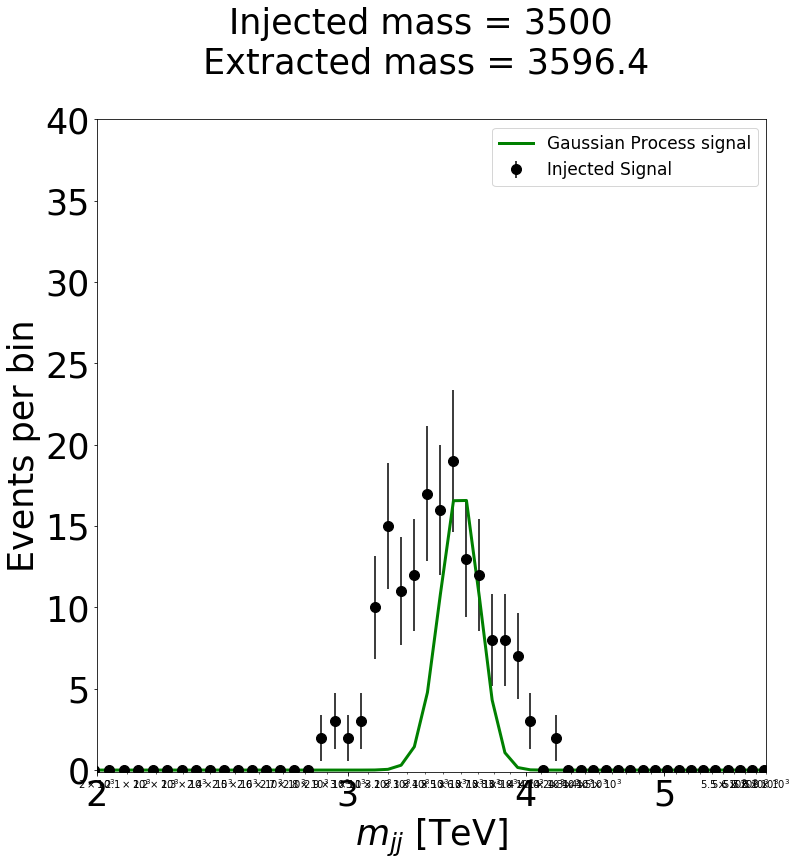

(99.99967180992176, 3596.4707287354076, 114.45899560216202, 9829.216766422116)
(99.99989655385475, 3528.175188426788, 129.58354654058124, 161.19631645537723)
(99.99996705680353, 3527.9296205024298, 129.62367117727513, 161.4504274047975)
(99.99999950139667, 3528.0199983293196, 129.6032250154191, 161.37674146185833)
(99.99999859868983, 3527.996128362218, 129.60368261806406, 161.3683084375424)
(99.99999865527667, 3527.9984566978724, 129.60274902361746, 161.38909129902987)
A, mass, tau 99.9999986553 3527.9984567 129.602749024 161.389091299
[6.61340583e-075 7.31016450e-073 8.12065925e-071 9.03895736e-069
 1.00505461e-066 1.18971168e-064 1.39514153e-062 1.61555996e-060
 1.96197290e-058 2.33219339e-056 2.70435672e-054 3.23706105e-052
 3.74483062e-050 4.17211721e-048 4.71876916e-046 5.08983457e-044
 5.21617793e-042 5.33270388e-040 5.39653148e-038 5.10205416e-036
 4.48841763e-034 3.83591604e-032 3.15838957e-030 2.48426910e-028
 1.77301526e-026 1.14315943e-024 6.89872559e-023 3.86171887e-021
 1.

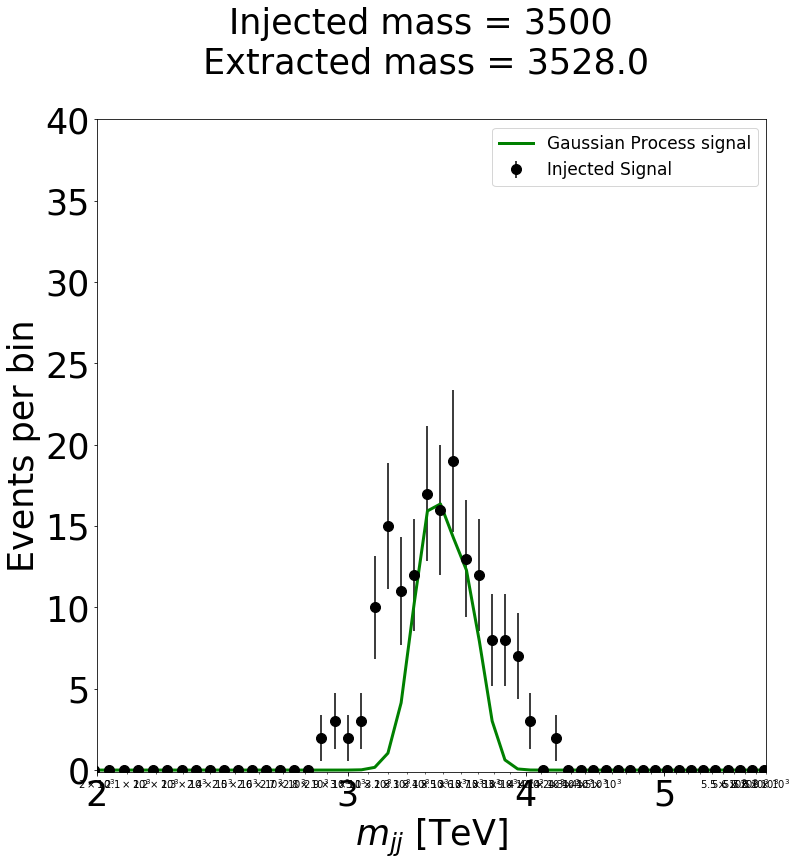

In [29]:

standardParamSets=[(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = noisy_smeared_countsO
        
        #plt.figure()
        #plt.plot(xvalO, smeared_countsO)
        #plt.xlim([1000,7000])
        #plt.xscale('log')
        
        lnProb = logLike_gp_fitgpsigonly(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigonly_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        

        A, mass, tau = best_fit_new 
        print "A, mass, tau", A, mass, tau
        kernel = A * ExpSquaredCenteredKernel(m = mass, t = tau)

        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGP, covGP = gp.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP, m, label)
        ####################################################################################

        
        lnProb2 = logLike_gp_fitgpsigonlyNew(xtoy,ydata, xtoyerr)
        bestval2, best_fit_new2 = fit_gp_fitgpsigonlyNew_minuit(lnProb2, False)
        if np.isinf(bestval2): 
            print "failed"
            continue
            
        A, mass, tau, L = best_fit_new2 
        print "A, mass, tau", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        
        gp2 = george.GP(kernel2)
        gp2.compute(xtoy, np.sqrt(ydata))
        meanGP2, covGP2 = gp2.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP2))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP2, m, label)

### Peak Signal

parameters (60, 3500, 250)
(1.000000002142725, 6487.000413266044, 100.0000000033143)
A, mass, tau 1.00000000214 6487.00041327 100.000000003
[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 1.23671309e-159
 1.64747551e-15

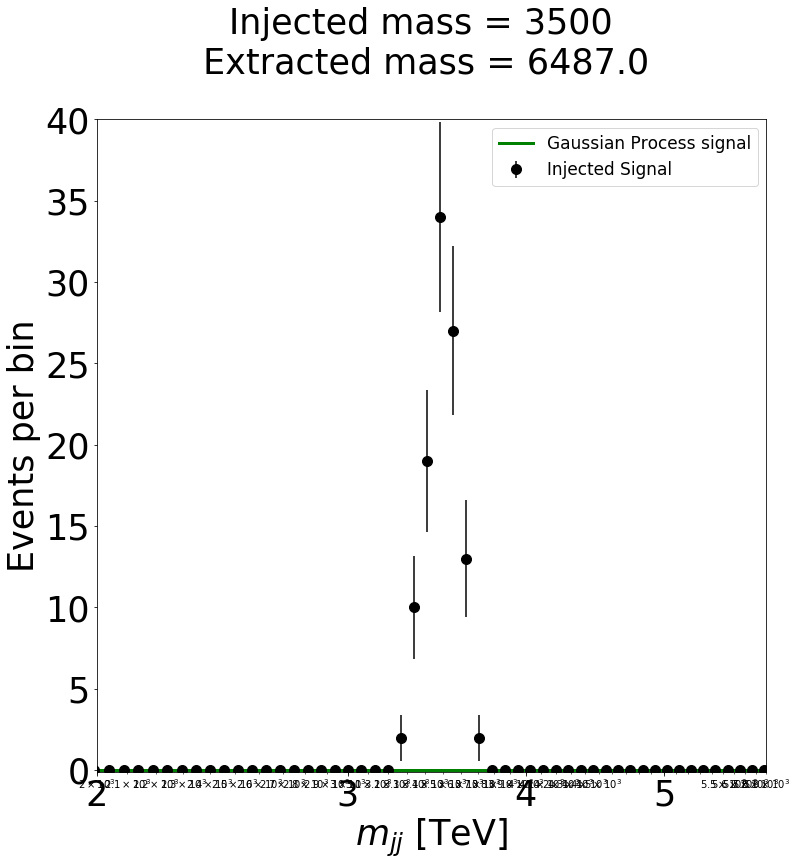

(1.0000025753179929, 3499.7936960721922, 100.00000000058715, 9999.997989303385)
(1.000000152713794, 6487.091570256449, 100.00002231928977, 9999.552332864283)
(1.000000007328124, 6486.973751399308, 100.00000429237383, 9999.742382168934)
(1.000000017978687, 6486.996289039749, 100.00000000181987, 9999.953943706714)
(1.000000000000275, 6487.000000012103, 100.00000000414089, 9999.999662655935)
(1.000000000000275, 6487.000000012103, 100.00000000414089, 9999.999662655935)
A, mass, tau 1.0 6487.00000001 100.000000004 9999.99966266
[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000

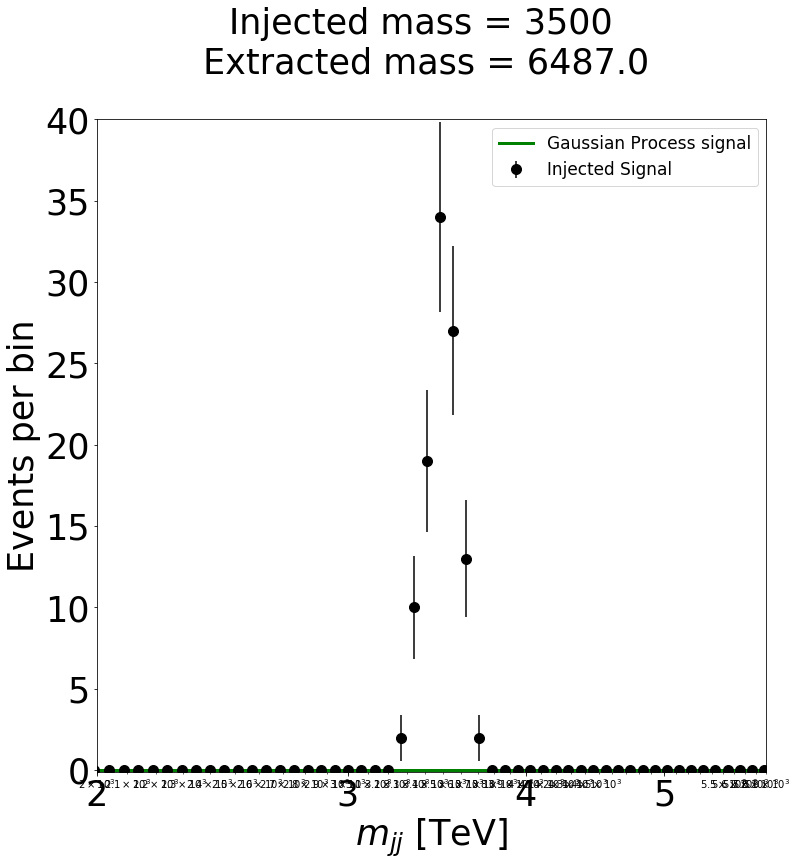

In [30]:
standardParamSets = [(60, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = peak(truth_steps, n, m, w, truth_step_size)        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = noisy_smeared_countsO
        
        #plt.figure()
        #plt.plot(xvalO, smeared_countsO)
        #plt.xlim([1000,7000])
        #plt.xscale('log')
        
        lnProb = logLike_gp_fitgpsigonly(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigonly_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        
        A, mass, tau = best_fit_new 
        print "A, mass, tau", A, mass, tau
        kernel = A * ExpSquaredCenteredKernel(m = mass, t = tau)

        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGP, covGP = gp.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP, m, label)

        #########################################################################
        
        lnProb2 = logLike_gp_fitgpsigonlyNew(xtoy,ydata, xtoyerr)
        bestval2, best_fit_new2 = fit_gp_fitgpsigonlyNew_minuit(lnProb2, False)
        if np.isinf(bestval2): 
            print "failed"
            continue
        
        print best_fit_new2
        A, mass, tau, L = best_fit_new2 
        print "A, mass, tau", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        
        gp2 = george.GP(kernel2)
        gp2.compute(xtoy, np.sqrt(ydata))
        meanGP2, covGP2 = gp2.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP2))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP2, m, label)

### Square Signal

parameters (20, 3500, 250)
(99.99990558627267, 1618.758328703469, 118.72545659638465)
(99.99990558627267, 1842.977396437766, 100.0003814696053)
(99.99990574758137, 2345.1577153941307, 108.48741251210694)
(99.99990558627267, 1000.0066551187521, 100.0003814696053)
(1.0051063996417655, 1005.1738577470144, 119.63549981864003)
(11.081503693878668, 6642.381677894764, 102.27682595638046)
(1.000007722107001, 6487.028293333461, 100.00000090456211)
(1.000000042326977, 6486.999740874377, 100.0000001849651)
(1.0000000765014563, 6487.00170339618, 100.00000001101597)
(1.0000000056113083, 6487.000748857138, 100.00000000042162)
(1.0000000009541137, 6487.000001728539, 100.0000000001734)
(1.000000000001187, 6487.000017376775, 100.00000000000016)
A, mass, tau 1.0 6487.00001738 100.0
[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+0

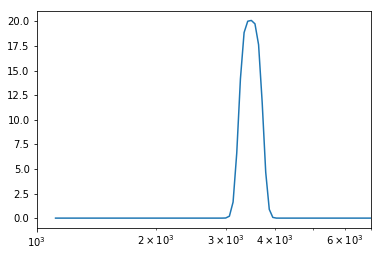

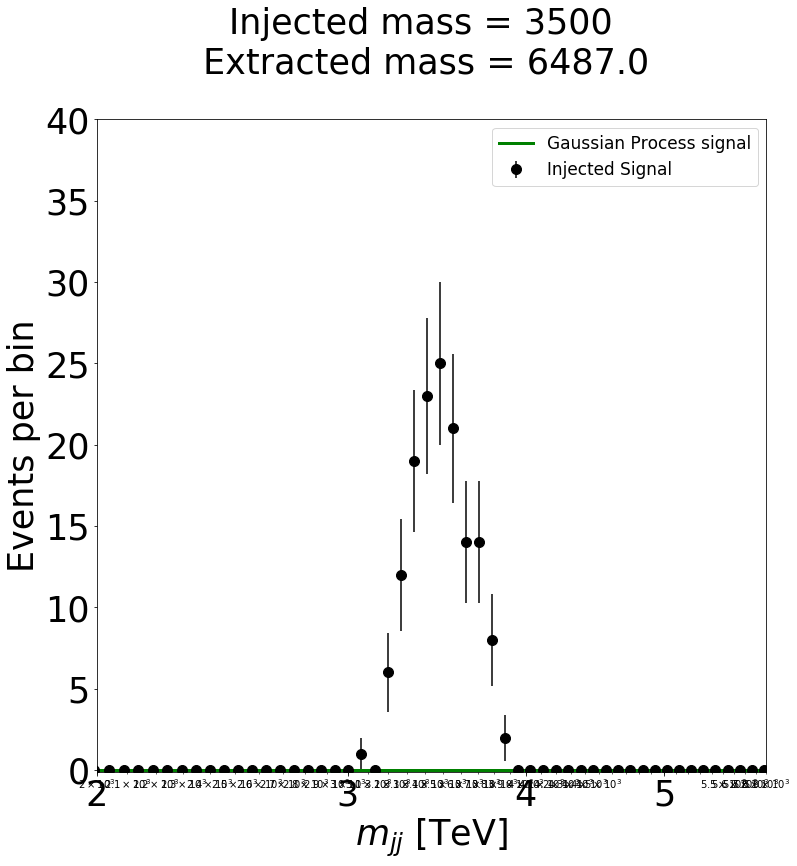

(1.0000008100680398, 1000.0000321667662, 100.00000376873386, 9999.999851577637)
(1.0000042298303995, 1000.0000000905928, 100.00000017037, 9999.988109889418)
(99.99999954849382, 3519.7307043491296, 100.00000000019473, 134.65746802580944)
(99.99995901169369, 3519.487126015658, 100.00000014000032, 134.5551999537814)
(99.99998525187553, 3519.5454204095686, 100.00000000605857, 134.57624673410524)
(99.99999808519841, 3519.5317749362503, 100.0000000010049, 134.57164993083495)
(99.99999980076404, 3519.530164863344, 100.00000000044773, 134.5980163153827)
(99.99999996174009, 3519.5226507518382, 100.00000000005787, 134.5883981708249)
(99.99999999999828, 3519.526424948577, 100.00000000001896, 134.5952071212189)
(99.99999999999828, 3519.526424948577, 100.00000000001896, 134.5952071212189)
A, mass, tau 100.0 3519.52642495 100.0 134.595207121
[4.05082987e-125 1.06621884e-121 2.82876252e-118 7.52682953e-115
 1.99838070e-111 5.88886472e-108 1.70747896e-104 4.84511830e-101
 1.48797760e-097 4.40642199e-0

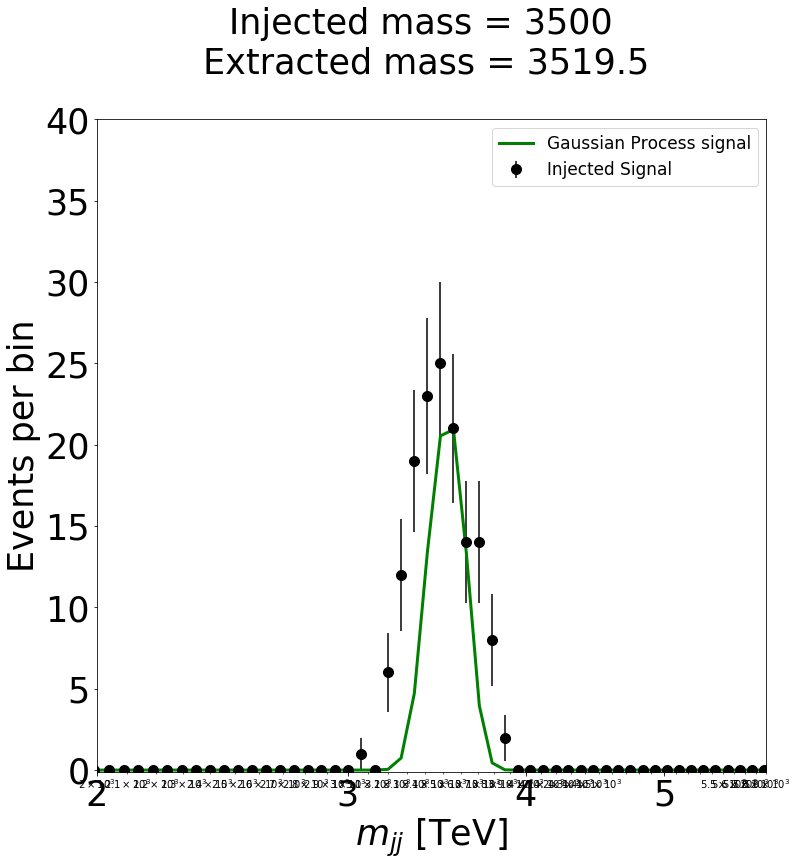

In [31]:
standardParamSets = [(20, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = square(truth_steps, n, m, w, truth_step_size)        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        lnProb = logLike_gp_fitgpsigonly(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigonly_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue

        A, mass, tau = best_fit_new 
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)

        gp = george.GP(kernel2)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGP, covGP = gp.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP, m, label)

        ##############################################################################
        
        lnProb2 = logLike_gp_fitgpsigonlyNew(xtoy,ydata, xtoyerr)
        bestval2, best_fit_new2 = fit_gp_fitgpsigonlyNew_minuit(lnProb2, False)
        if np.isinf(bestval2): 
            print "failed"
            continue
        
        print best_fit_new2
        A, mass, tau, L = best_fit_new2 
        print "A, mass, tau", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        
        gp2 = george.GP(kernel2)
        gp2.compute(xtoy, np.sqrt(ydata))
        meanGP2, covGP2 = gp2.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP2))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP2, m, label)
        

### Right Triangle

parameters (40, 3520, 250)
(99.99980782704296, 2134.3141224561214, 100.0003814696053)
(99.99990558627267, 1000.0057220440796, 101.67876534639811)
(99.99971865914, 1000.0007914733269, 100.49648318671058)
(1.0000001996821768, 6486.9837670757315, 100.00001761991557)
(1.0000003178140862, 6487.009199830324, 100.00000001257081)
(1.0000000196286927, 6487.00174967267, 100.00000000061058)
(1.0000000000022806, 6487.000051385883, 100.00000000000233)
A, mass, tau 1.0 6487.00005139 100.0
[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000


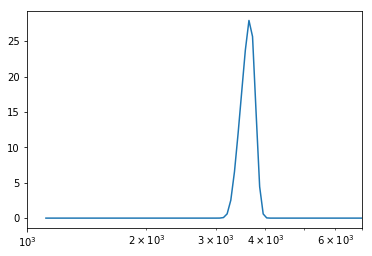

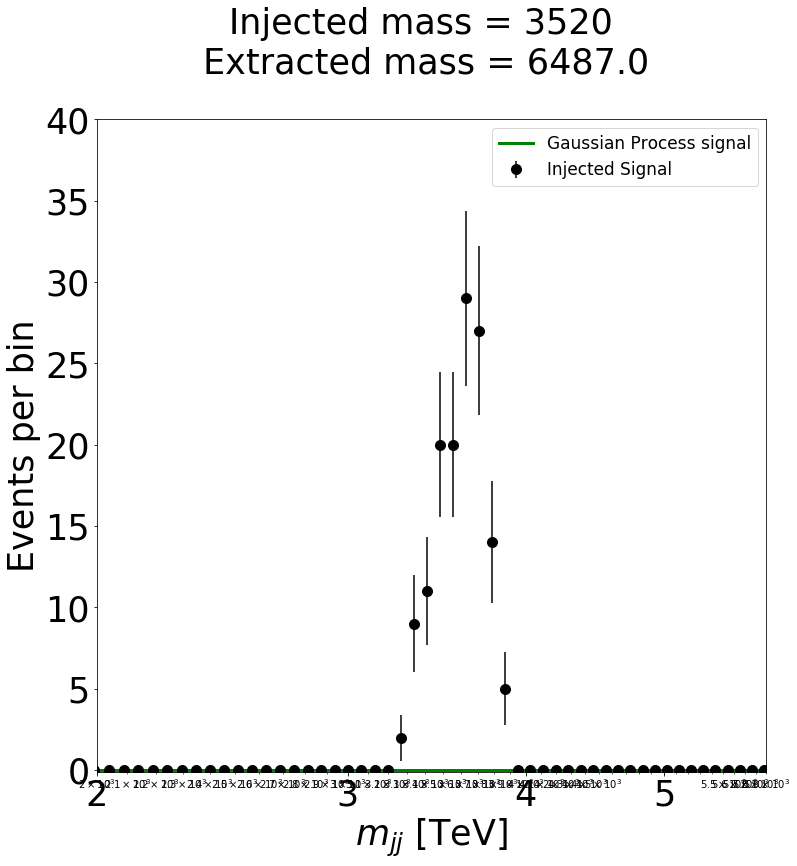

(1.0000000061312586, 1000.0000113834988, 100.00000065693374, 9999.998664879455)
(99.99987844931367, 3627.249804414427, 100.00000029160122, 127.39772433376544)
(99.9999995732281, 3627.111415948711, 100.0000000978557, 127.57233992943847)
(99.9999988146295, 3627.1118748456693, 100.00000000001461, 127.56107045209811)
(99.9999988146295, 3627.1118748456693, 100.00000000001461, 127.56107045209811)
A, mass, tau 99.9999988146 3627.11187485 100.0 127.561070452
[1.34387661e-136 5.04487228e-133 1.91922075e-129 7.36209354e-126
 2.83311677e-122 1.22317107e-118 5.22416090e-115 2.19536795e-111
 1.00928415e-107 4.49835227e-104 1.93264400e-100 8.84531676e-097
 3.84200846e-093 1.57427601e-089 6.68199763e-086 2.63200652e-082
 9.56063532e-079 3.49318164e-075 1.26713435e-071 4.12063012e-068
 1.19319818e-064 3.32390299e-061 8.78440788e-058 2.17128257e-054
 4.58097083e-051 8.18924697e-048 1.32304255e-044 1.90268761e-041
 2.39836435e-038 2.60841494e-035 2.40869396e-032 1.85792970e-029
 1.17730404e-026 6.025572

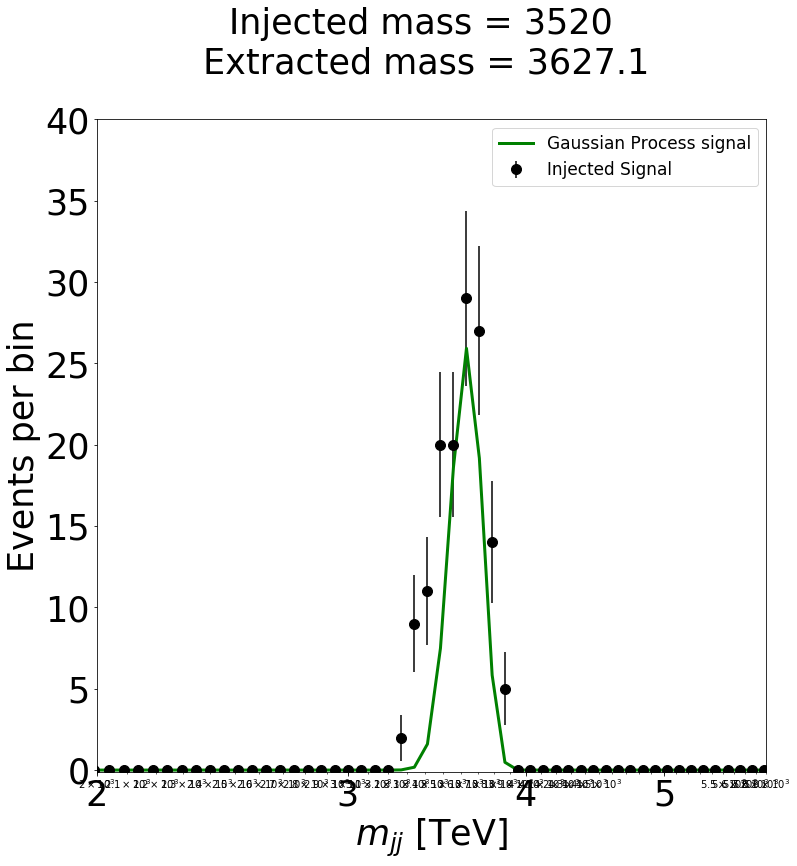

In [32]:
standardParamSets = [(40, 3520, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = triangle(truth_steps, n, m, w, truth_step_size)        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        lnProb = logLike_gp_fitgpsigonly(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigonly_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        

        A, mass, tau = best_fit_new 
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        
        gp = george.GP(kernel2)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGP, covGP = gp.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP, m, label)


        ##############################################################################
        
        lnProb2 = logLike_gp_fitgpsigonlyNew(xtoy,ydata, xtoyerr)
        bestval2, best_fit_new2 = fit_gp_fitgpsigonlyNew_minuit(lnProb2, False)
        if np.isinf(bestval2): 
            print "failed"
            continue
        
        print best_fit_new2
        A, mass, tau, L = best_fit_new2 
        print "A, mass, tau", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        
        gp2 = george.GP(kernel2)
        gp2.compute(xtoy, np.sqrt(ydata))
        meanGP2, covGP2 = gp2.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP2))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP2, m, label)

## NO SMEARING OR NOISE ON SIGNAL

parameters (20, 3500, 250)
(743.9812786957399, 3544.1593647165714, 156.81069419905282, 9999.164639414175)
(743.6981679610512, 3544.1899939435534, 156.82365117026805, 9997.201647315438)
(742.7998970698712, 3544.1932520596097, 156.8275708497192, 9999.982994882475)
A, mass, tau, L 742.79989707 3544.19325206 156.82757085 9999.98299488


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 69.05267450995142


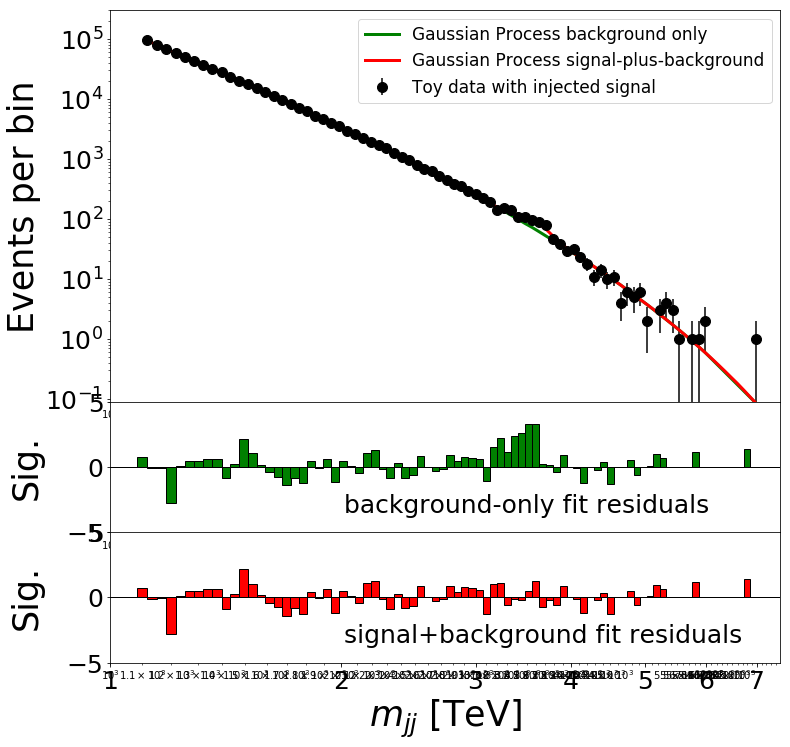

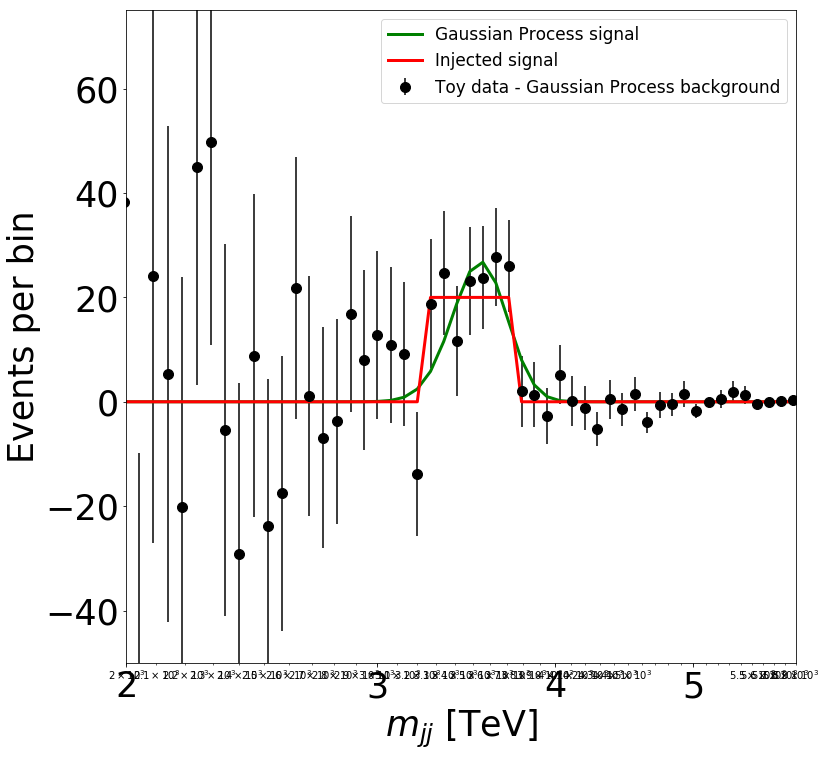

In [33]:


standardParamSets = [(20, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = square(xtoy, n, m, w, xtoyerr)
        ydata = signal+ytoy
        
        signalO = square(xvalO, n, m, w, xerrO)
        ydataO = yvalO+signalO
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy, ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
 
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        #makePrettyPlots_signalOnly2(xvalO, ydataO-newy, newys, ydataO, signalO, m, label)
        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, signalO, m, label)
        